## Hubbard model

The Hubbard model is implemented using [arXiv:2504.02385](https://arxiv.org/abs/2504.02385).

# The main formular from the paper
We implement it using RY as a rotational operator and use jax, as the clean python cell (documented at the further down) explodes with memory.


	
$$
\begin{bmatrix}
P(e^{i H}) & * \\
* & *
\end{bmatrix}
=
\Bigg(
\prod_{j=1}^d RY\big(\theta_{d+j}\big)\, \begin{bmatrix}
0 & 0 \\
0 & e^{-i H}
\end{bmatrix}

\Bigg)
\Bigg(
\prod_{j=1}^{d} RY\big(\theta_j\big)\,  \begin{bmatrix}
e^{i H} & 0 \\
0 & 0
\end{bmatrix} 
\Bigg)
RY\big(\theta_0)
$$




In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

d = 50

def P(x):
    return jnp.cos(x)**(d-2)

def R(theta):
    return jnp.array([
        [jnp.cos(theta/2), -jnp.sin(theta/2)],
        [jnp.sin(theta/2),  jnp.cos(theta/2)]
    ], dtype=jnp.complex128)

def U_signal(x, which):
    if which == 0:
        return jnp.array([[jnp.exp(1j*x), 0.0],
                          [0.0, 1.0]], dtype=jnp.complex128)
    else:
        return jnp.array([[1.0, 0.0],
                          [0.0, jnp.exp(-1j*x)]], dtype=jnp.complex128)

from jax import lax

@jax.jit
def qsp_matrix2(angles, x):
    d = (angles.shape[0] - 1) // 2

    theta0 = angles[0]
    theta1 = angles[1:1+d]
    theta2 = angles[1+d:1+2*d]

    M = jnp.array([
        [jnp.cos(theta0/2), -jnp.sin(theta0/2)],
        [jnp.sin(theta0/2),  jnp.cos(theta0/2)]
    ], dtype=jnp.complex128)

    def loop0(M, theta):
        M = jnp.array([
        [jnp.cos(theta/2), -jnp.sin(theta/2)],
        [jnp.sin(theta/2),  jnp.cos(theta/2)]
    ], dtype=jnp.complex128) @ jnp.array([[jnp.exp(1j*x), 0.0],
                          [0.0, 1.0]], dtype=jnp.complex128) @ M
        return M, None

    def loop1(M, theta):
        M = jnp.array([
        [jnp.cos(theta/2), -jnp.sin(theta/2)],
        [jnp.sin(theta/2),  jnp.cos(theta/2)]
    ], dtype=jnp.complex128) @ jnp.array([[1.0, 0.0],
                          [0.0, jnp.exp(-1j*x)]], dtype=jnp.complex128) @ M
        return M, None

    M, _ = lax.scan(loop0, M, theta1)
    M, _ = lax.scan(loop1, M, theta2)

    return M

@jax.jit
def loss(angles):
    xs = jnp.linspace(0.0, 1.5, d * 7 // 11)

    def loss_x(x):
        M = qsp_matrix2(angles, x)
        amp = M[0,0]
        return jnp.abs(amp - P(x))**2

    return jnp.sum(jax.vmap(loss_x)(xs))

loss_grad = jax.jit(jax.grad(loss))


import numpy as np
from scipy.optimize import minimize

loss_np = lambda a: np.array(loss(jnp.array(a)), dtype=float)

init_angles = np.random.uniform(0, np.pi, 2*d+1)

try:
    opt_angles = np.load(f'opt_angles_d{d}.npy')
    print(f"Loaded angles from opt_angles_d{d}.npy")
    print(f"Shape: {opt_angles.shape}")
except FileNotFoundError:
    print("No saved angles found, starting optimization.")
    res = minimize(loss, init_angles, method="BFGS", options={"maxiter":500}, jac=loss_grad)
    opt_angles = res.x
    print(res)
print("Optimized angles:", opt_angles)



Loaded angles from opt_angles_d50.npy
Shape: (101,)
Optimized angles: [ 3.55602473  1.23981828 -2.22132311  0.94231154 -0.84650715  1.75325838
  4.47690326 -0.21469303  1.20259078  0.7745557   4.98617656  0.40699554
  1.21016465  1.45136754  1.75905322  3.51025401  0.07946871  4.11346681
  2.06365728 -0.25292963  3.78180083  1.8318456   2.46446398  2.79837056
  1.48073263  1.48332352 -0.25770676  0.70990833  1.31907089  3.86288943
  0.48975249  3.07579659  0.77906422  2.89186316  2.91615639  3.4434313
 -0.39320007  3.21701513  2.06151788  1.27307172  0.88799579  1.37441192
  2.70918556  3.38903528  2.19656076  4.02108736 -0.12672168 -0.44579305
  3.77580767  1.2664704  -0.51212643  2.03058917  1.89584228  1.41001795
  0.36693616 -0.2323254   3.73726954  0.22673645  1.83480782  2.59444432
  2.92678562 -0.02123848 -0.05701252  1.47937831  3.63158999  0.28169983
  0.03609267  1.72352239  2.69020283  2.50545642  1.03089377  1.39622085
  4.71999471  0.9520318  -0.74073738  3.87900436  0.368

In [2]:
x_test = 0.4
M = qsp_matrix2(opt_angles, x_test)
print("Amplitude |0>:", M[0,0])
print("P(cos(x)):", P(x_test))

Amplitude |0>: (0.019264336336176163-9.693572339397605e-05j)
P(cos(x)): 0.019312689431863272


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "16"
import pennylane as qml
import numpy as np
from scipy.sparse.linalg import eigsh
import os
L_x = 2
L_y = 4
boundary_conditions = [False, False]

t = 1
U = 8

# This is the characteristic of the polynomial filter with cos(x)^50, which we later use
optimal_x_for_filter = 0.0

H_penny = qml.spin.fermi_hubbard('rectangle',[L_x, L_y], hopping=t, coulomb=U, boundary_condition=boundary_conditions)

H_original = H_penny.sparse_matrix()
# print(f"Numpy Ground state energy: {np.min(np.linalg.eigvalsh(H_original))}")

eig_vals, eig_vecs = eigsh(H_penny.sparse_matrix(), k=6, which='SA')
print(f"PennyLane Ground state energy: {np.min(eig_vals)}")

H_matrix = H_penny.sparse_matrix()
eig_max = eigsh(H_matrix, k=1, which='LA', return_eigenvectors=False)[0]
eig_min = np.min(eig_vals)
print(f"Max eigenvalue: {eig_max}")
print(f"Min eigenvalue: {eig_min}")

print("Shifting Hamiltonian...")
ops = H_penny.operands
coefs = [op.scalar for op in ops]
obs = [op.base for op in ops]
H_penny = qml.Hamiltonian(coefs, obs)

H_penny = (H_penny - qml.Identity(wires=H_penny.wires) * (eig_min - optimal_x_for_filter * (eig_max - eig_min))) / (eig_max - eig_min)
H_penny = qml.Hamiltonian(H_penny.coeffs, H_penny.ops)

H_matrix = H_penny.sparse_matrix()
eig_max = eigsh(H_matrix, k=1, which='LA', return_eigenvectors=False)[0]
eig_min = eigsh(H_matrix, k=1, which='SA', return_eigenvectors=False)[0]
print(f"Max eigenvalue: {eig_max}")
print(f"Min eigenvalue: {eig_min}")

PennyLane Ground state energy: -6.820869538931483
Max eigenvalue: 64.00000000000004
Min eigenvalue: -6.820869538931483
Shifting Hamiltonian...
Max eigenvalue: 1.0000000000000036
Min eigenvalue: -8.101036641431216e-16


In [2]:
H_penny

(
    -0.007060065814712156 * (Y(0) @ Z(1) @ Y(2))
  + -0.007060065814712156 * (X(0) @ Z(1) @ X(2))
  + 0.225922106070789 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
  + -0.007060065814712156 * (Y(1) @ Z(2) @ Y(3))
  + -0.007060065814712156 * (X(1) @ Z(2) @ X(3))
  + -0.007060065814712156 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Y(8))
  + -0.007060065814712156 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ X(8))
  + -0.007060065814712156 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Y(9))
  + -0.007060065814712156 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ X(9))
  + -0.007060065814712156 * (Y(2) @ Z(3) @ Y(4))
  + -0.007060065814712156 * (X(2) @ Z(3) @ X(4))
  + -0.007060065814712156 * (Y(3) @ Z(4) @ Y(5))
  + -0.007060065814712156 * (X(3) @ Z(4) @ X(5))
  + -0.007060065814712156 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10))
  + -0.007060065814712156 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7)

In [3]:
ops = H_penny.operands
coefs = [op.scalar for op in ops]
print(f"Number of terms: {len(ops)}")
print(f"Coefficients: {coefs[:5]}...")  # Show first 5
print(f"Operators: {ops[:5]}...")  # Show first 5

Number of terms: 66
Coefficients: [np.float64(-0.007060065814712156), np.float64(-0.007060065814712156), np.float64(0.225922106070789), np.float64(-0.007060065814712156), np.float64(-0.007060065814712156)]...
Operators: (-0.007060065814712156 * (Y(0) @ Z(1) @ Y(2)), -0.007060065814712156 * (X(0) @ Z(1) @ X(2)), 0.225922106070789 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), -0.007060065814712156 * (Y(1) @ Z(2) @ Y(3)), -0.007060065814712156 * (X(1) @ Z(2) @ X(3)))...


In [9]:
obs = [op.base for op in ops]
grouped = qml.pauli.group_observables(obs, coefs, grouping_type='commuting')
print(f"Number of groups: {len(grouped)}")
print(f"Shape of first group: {len(grouped[0])}")
print(f"Shape of second group: {len(grouped[1])}")
for g in grouped[0]:
    print(len(g))
for g in grouped[1]:
    print(len(g))
    
obs_flat = [item for sublist in grouped[0] for item in sublist]
coeffs_flat = [item for sublist in grouped[1] for item in sublist]

grouped_H = qml.Hamiltonian(coeffs_flat, obs_flat)
eig_vals_grouped, _ = eigsh(grouped_H.sparse_matrix(), k=6, which='SA')
print(f"Check Ground state energy: {np.min(eig_vals_grouped)}")

Number of groups: 2
Shape of first group: 4
Shape of second group: 4
16
26
16
8
16
26
16
8
Check Ground state energy: -7.957432732529581e-16


The following is just checking the TrotterProduct to convince ourself it works :)

In [7]:
dev = qml.device("lightning.qubit", wires=H_penny.num_wires)
@qml.qnode(dev)
def my_circ(time, n_steps=1, order=2):
    # Prepare some state
    for w in range(H_penny.num_wires):
        qml.Hadamard(w)
    
    # Evolve according to H
    qml.TrotterProduct(grouped_H, time=time, n=n_steps, order=order, check_hermitian=True)

    # Measure some quantity
    return qml.state()

In [8]:
from scipy.linalg import expm


time = 1.0
order = 2
n_steps = 10

psi_trotter = my_circ(time, n_steps, order)

# Initial state (same as in circuit: all Hadamards)
psi_0 = np.ones(2**grouped_H.num_wires) / np.sqrt(2**grouped_H.num_wires)

# Compute expectation value using exact matrix exponential
if grouped_H.sparse_matrix().shape[0] < 1000:
    print("Using grouped Hamiltonian for exact evolution.")
    H_matrix = grouped_H.sparse_matrix().toarray()


    # Exact time evolution
    U_exact = expm(1j * time * H_matrix)

    

    # Apply exact evolution
    psi_exact = U_exact @ psi_0

    print(f"Exact state (first 10 elements): {psi_exact[:10]}")
    print(f"Trotter state (first 10 elements): {psi_trotter[:10]}")
    print(f"Fidelity: {abs(np.vdot(psi_exact, psi_trotter))**2}")
else:
    print("Exact evolution skipped due to large matrix size.")

Exact evolution skipped due to large matrix size.


In [9]:
grouped_H.sparse_matrix().shape[0]

65536

In [10]:
# Remap wires of grouped_H to make wire 0 free for control
def our_R(theta, wire):
    qml.RY(theta, wires=wire) # @ qml.RZ(np.pi, wires=wire)


wire_map = {i: i+1 for i in range(grouped_H.num_wires)}
grouped_H_new = qml.map_wires(grouped_H, wire_map)


def iterate(angles):
    d = len(angles)//2
    theta0 = angles[0]
    theta1 = angles[1:d+1]
    theta2 = angles[d+1:2*d+1]
    
    for _ in range(1):
        our_R(theta0, wire=0)
        
        # Erste Schleife: wirkt auf |0> Komponente
        for t in theta1:
            qml.ctrl(qml.TrotterProduct(grouped_H_new, time=1.0, n=n_steps, order=order, check_hermitian=True), control=0, control_values=0)
            our_R(t, wire=0)
            
        # Zweite Schleife: wirkt auf |1> Komponente
        for t in theta2:
            qml.ctrl(qml.TrotterProduct(grouped_H_new, time=-1.0, n=n_steps, order=order, check_hermitian=True), control=0, control_values=1)
            our_R(t, wire=0)



dev = qml.device("lightning.qubit", wires=grouped_H.num_wires + 1)

# from catalyst import qjit
# @qjit
@qml.qnode(dev)
def my_circ_ctrl(angles=None):
    # Prepare some state
    for w in range(1, grouped_H.num_wires + 1):
        qml.Hadamard(w)
    iterate(angles)
        
    # Measure some quantity
    return qml.state()     


In [11]:
rr = my_circ_ctrl(opt_angles)

In [12]:
r_now = psi_0  # rr.reshape(-1,2)[:,0]
energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of initial state: {energy}")
r_now = rr.reshape(2,-1)[0]
energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of Hamiltonian: {energy}")
energy = np.vdot(r_now, H_original @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of original Hamiltonian: {energy}")
print(f"Norm r_now: {np.vdot(r_now, r_now).real}, Norm rr: {np.vdot(rr, rr).real}")

Expectation value of initial state: 0.32223368178763223
Expectation value of Hamiltonian: 0.10237343839726057
Expectation value of original Hamiltonian: 0.4293063860527773
Norm r_now: 0.13602488836569918, Norm rr: 0.9999999999936547


### The following can not be implemented without post selection after every iteration, so it is just to check if the algorithm would work

In [13]:
psi = psi_0

@qml.qnode(dev)
def my_one_iter(angles=None):
    # Prepare some state
    qml.StatePrep(psi, wires=range(1, grouped_H.num_wires + 1))
    iterate(angles)
        
    # Measure some quantity
    return qml.state()

r_now = psi    
probability = 1.0
plot_qsp = []
plot_E = []

In [14]:

energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of shifted and scaled Hamiltonian: {energy}")
energy = np.vdot(r_now, H_original @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of original Hamiltonian: {energy}")
p_local = np.vdot(r_now, r_now).real
probability = probability * p_local
print(f"prob r_now: {p_local}, probability to now: {probability}")
# plot_qsp.append(0)
# plot_E.append(energy)

Expectation value of shifted and scaled Hamiltonian: 0.32223368178763223
Expectation value of original Hamiltonian: 16.0
prob r_now: 1.0, probability to now: 1.0


In [15]:
rr2 = rr
# rr2 = my_one_iter(opt_angles)
r_now = rr2.reshape(2,-1)[0]


In [16]:

energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of shifted and scaled Hamiltonian: {energy}")
energy = np.vdot(r_now, H_original @ r_now).real / np.vdot(r_now, r_now).real
print(f"Expectation value of original Hamiltonian: {energy}")
p_local = np.vdot(r_now, r_now).real
probability = probability * p_local
print(f"prob r_now: {p_local}, probability to now: {probability}")
plot_qsp.append(d)
plot_E.append(energy)

Expectation value of shifted and scaled Hamiltonian: 0.10237343839726057
Expectation value of original Hamiltonian: 0.4293063860527773
prob r_now: 0.13602488836569918, probability to now: 0.13602488836569918


In [17]:
for pp in range(200):
    print(f"--- Iteration {pp+2} --- {(pp+2) * d} QSP steps")
    psi = r_now / np.sqrt(np.vdot(r_now, r_now).real)
    rr2 = my_one_iter(opt_angles)
    r_now = rr2.reshape(2,-1)[0]

    energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
    print(f"Expectation value of shifted and scaled Hamiltonian: {energy}")
    energy = np.vdot(r_now, H_original @ r_now).real / np.vdot(r_now, r_now).real
    print(f"Expectation value of original Hamiltonian: {energy}")
    p_local = np.vdot(r_now, r_now).real
    probability = probability * p_local
    print(f"prob r_now: {p_local}, probability to now: {probability}")
    plot_qsp.append((pp+2)*d)
    plot_E.append(energy)

--- Iteration 2 --- 100 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.06480119253336859
Expectation value of original Hamiltonian: -2.231592736558577
prob r_now: 0.6187912398221892, probability to now: 0.08417100931848587
--- Iteration 3 --- 150 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.051730059037652695
Expectation value of original Hamiltonian: -3.1573017765846303
prob r_now: 0.7957481309853774, probability to now: 0.06697892334833792
--- Iteration 4 --- 200 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.046178494244084704
Expectation value of original Hamiltonian: -3.5504684225668366
prob r_now: 0.8600826370123283, probability to now: 0.05760740901768509
--- Iteration 5 --- 250 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.043013179481431116
Expectation value of original Hamiltonian: -3.774638766422375
prob r_now: 0.887072028236139, probability to now: 0.05110192115874675
--- Iteration 6 --- 300 QSP step

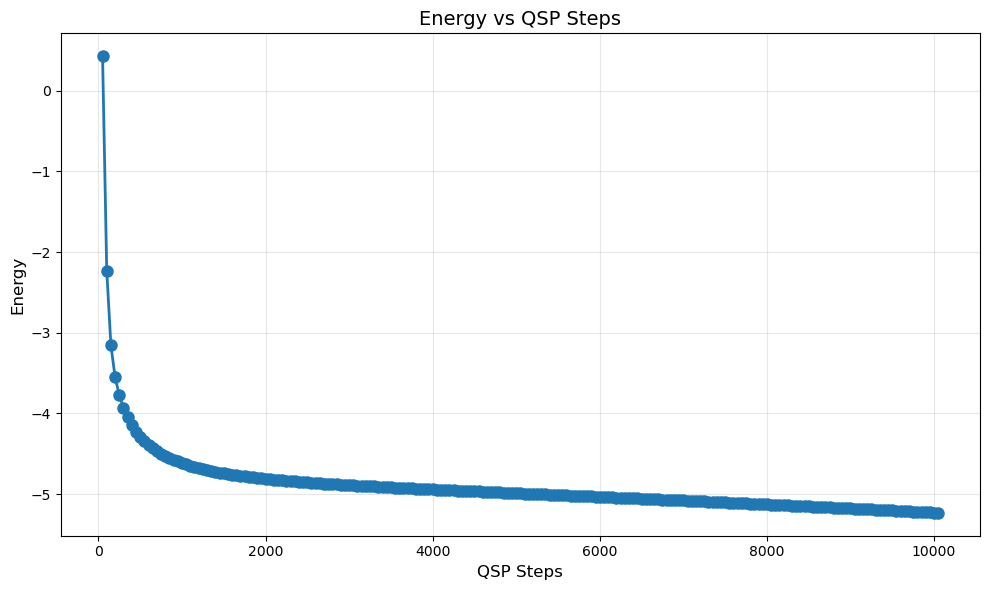

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(plot_qsp, plot_E, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('QSP Steps', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('Energy vs QSP Steps', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
for pp in range(200,400):
    print(f"--- Iteration {pp+2} --- {(pp+2) * d} QSP steps")
    psi = r_now / np.sqrt(np.vdot(r_now, r_now).real)
    rr2 = my_one_iter(opt_angles)
    r_now = rr2.reshape(2,-1)[0]

    energy = np.vdot(r_now, H_penny.sparse_matrix() @ r_now).real / np.vdot(r_now, r_now).real
    print(f"Expectation value of shifted and scaled Hamiltonian: {energy}")
    energy = np.vdot(r_now, H_original @ r_now).real / np.vdot(r_now, r_now).real
    print(f"Expectation value of original Hamiltonian: {energy}")
    p_local = np.vdot(r_now, r_now).real
    probability = probability * p_local
    print(f"prob r_now: {p_local}, probability to now: {probability}")
    plot_qsp.append((pp+2)*d)
    plot_E.append(energy)

--- Iteration 202 --- 10100 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.022366530829011865
Expectation value of original Hamiltonian: -5.236852377051517
prob r_now: 0.9752359001447404, probability to now: 4.8240507527227356e-05
--- Iteration 203 --- 10150 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.02232711482315791
Expectation value of original Hamiltonian: -5.2396438528598495
prob r_now: 0.9753121914892667, probability to now: 4.704955511493458e-05
--- Iteration 204 --- 10200 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.022287555222920686
Expectation value of original Hamiltonian: -5.2424454981472595
prob r_now: 0.9753885889547504, probability to now: 4.58915991745048e-05
--- Iteration 205 --- 10250 QSP steps
Expectation value of shifted and scaled Hamiltonian: 0.02224785112941694
Expectation value of original Hamiltonian: -5.245257376573451
prob r_now: 0.975465093085747, probability to now: 4.476565306061212e-05
--- Itera

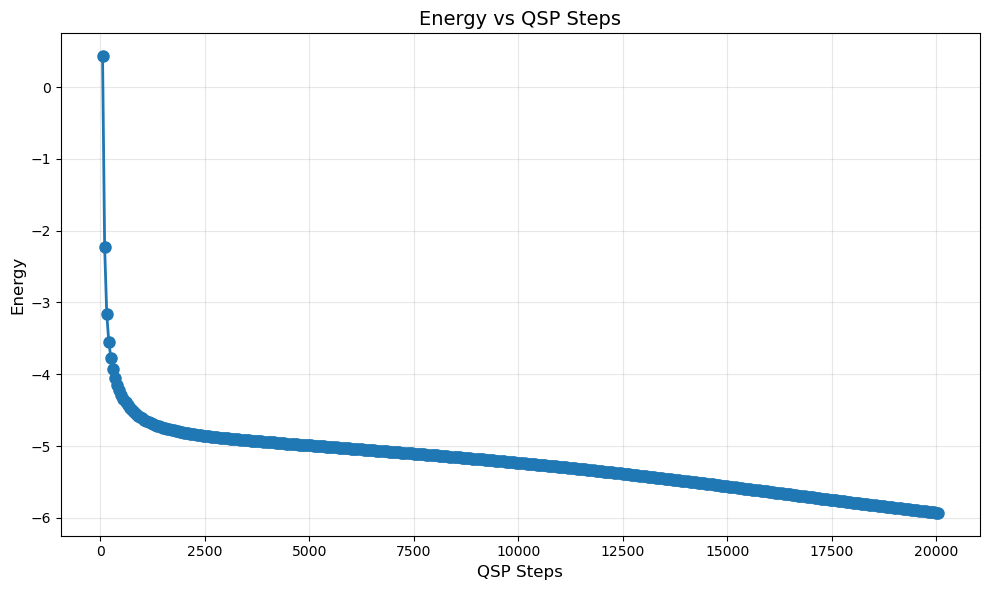

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(plot_qsp, plot_E, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('QSP Steps', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('Energy vs QSP Steps', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
_, ev =eigsh(H_original, k=1, which='SA', return_eigenvectors=True)
print(f"fidelity: {np.abs(np.vdot(r_now, ev[:,0]))**2}")

fidelity: 0.162644186207747


## Write and read angles to and from file.

In [22]:
np.save(f'opt_angles_d{d}.npy', opt_angles)
print(f"Saved angles to opt_angles_d{d}.npy")

Saved angles to opt_angles_d50.npy


In [23]:
opt_angles = np.load(f'opt_angles_d{d}.npy')
print(f"Loaded angles from opt_angles_d{d}.npy")
print(f"Shape: {opt_angles.shape}")

Loaded angles from opt_angles_d50.npy
Shape: (101,)


## Non jax version of angle finding, but explodes in memory due to @

In [24]:
# This is what I wanted to implement for clean reading, but it explodes in memory usage due to @
# 
# import numpy as np
# from scipy.optimize import minimize

# d = 10  # Grad der QSP-Schleifen

# # Zielpolynom: P(cos(x))
# def P(x):
#     return 0.0 + 1.0*np.cos(x)**(d-1)


# def R(theta, phi=0, gamma=0):
#     # return qml.matrix(qml.RY(theta, wires=0)) #  @ qml.RZ(np.pi, wires=0))
#     return np.array([[np.cos(theta/2), -np.sin(theta/2)],
#                     [np.sin(theta/2), np.cos(theta/2)]])
#     return np.array([
#         [np.exp(1j*(gamma+phi))*np.cos(theta), np.exp(1j*phi)*np.sin(theta)],
#         [np.exp(1j*gamma)*np.sin(theta), -np.cos(theta)]
#     ])

# def U_signal(x, which=0):
#     """Signal: wirkt auf |0> oder |1> Komponente"""
#     if which==0:
#         return np.diag([np.exp(1j*x), 1])
#     else:
#         return np.diag([1, np.exp(-1j*x)])
# def qsp_matrix(angles, x):
#     d = len(angles)//2
#     theta0 = angles[0]
#     theta1 = angles[1:d+1]
#     theta2 = angles[d+1:2*d+1]
    
#     # Start-Rotation
#     M = R(theta0)
    
#     # Erste Schleife: wirkt auf |0> Komponente
#     for t in theta1:
#         M = R(t) @ U_signal(x, 0) @ M
        
#     # Zweite Schleife: wirkt auf |1> Komponente
#     for t in theta2:
#         M = R(t) @ U_signal(x, 1) @ M
    
#     return M

# xs = np.linspace(0, np.pi, 20)
# def loss(angles):
#     L = 0
#     for x in xs:
#         M = qsp_matrix(angles, x)
#         amp = M[0,0]  # |0> Amplitude
#         L += np.abs(amp - P(x))**2
#     return L
# np.random.seed(42)
# init_angles = np.random.uniform(0, np.pi, 2*d+1)  # zwei Sets

# res = minimize(loss, init_angles, method='L-BFGS-B', options={'maxiter':500})
# opt_angles = res.x
# print("Optimierte Winkel:", opt_angles)

# x_test = 0.5
# M = qsp_matrix(opt_angles, x_test)
# print("Amplitude |0>:", M[0,0])
# print("Ziel P(cos(x)):", P(x_test))